In [33]:
import torch
import torch.nn as nn
import torchtext.legacy.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [34]:
# download data
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [35]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename columns to something better
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df2 = df[['data', 'b_labels']]
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [37]:
df2.to_csv('spam2.csv', index=False)

In [38]:
TEXT = ttd.Field(sequential=True,
                 batch_first=True,
                 lower=False,
                 tokenize='spacy',
                 pad_first=True)


LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(path='spam2.csv',
                             format='csv',
                             skip_header=True,
                             fields=[('data', TEXT), ('label', LABEL)])

In [39]:
train_dataset, test_dataset = dataset.split() # default is 0.7

In [40]:
TEXT.build_vocab(train_dataset,)
vocab = TEXT.vocab
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fe1e8078350>>,
            {'<unk>': 0,
             '<pad>': 1,
             '.': 2,
             'to': 3,
             'I': 4,
             'you': 5,
             ',': 6,
             '?': 7,
             'a': 8,
             '!': 9,
             'the': 10,
             '...': 11,
             'i': 12,
             'in': 13,
             'and': 14,
             'is': 15,
             'u': 16,
             'me': 17,
             '..': 18,
             'for': 19,
             'my': 20,
             'of': 21,
             'it': 22,
             'your': 23,
             '&': 24,
             'have': 25,
             'that': 26,
             'on': 27,
             "'s": 28,
             '2': 29,
             ' ': 30,
             'do': 31,
             ';': 32,
             ':': 33,
             'call': 34,
             'not': 35,
             'or': 36,
             'are': 37,
             'no

In [41]:
vocab.itos

['<unk>',
 '<pad>',
 '.',
 'to',
 'I',
 'you',
 ',',
 '?',
 'a',
 '!',
 'the',
 '...',
 'i',
 'in',
 'and',
 'is',
 'u',
 'me',
 '..',
 'for',
 'my',
 'of',
 'it',
 'your',
 '&',
 'have',
 'that',
 'on',
 "'s",
 '2',
 ' ',
 'do',
 ';',
 ':',
 'call',
 'not',
 'or',
 'are',
 'now',
 "'m",
 "n't",
 'get',
 'at',
 'will',
 'be',
 'U',
 'so',
 'with',
 'nt',
 'ur',
 '4',
 '*',
 ')',
 'You',
 '-',
 'but',
 'can',
 'up',
 'lt;#&gt',
 'from',
 'we',
 '/',
 'just',
 'know',
 'out',
 'go',
 'this',
 'all',
 'when',
 'got',
 "'ll",
 'if',
 '"',
 'was',
 'like',
 'come',
 'am',
 'No',
 'he',
 'then',
 'there',
 'time',
 'only',
 'day',
 'want',
 'home',
 'what',
 'Ok',
 'How',
 'Call',
 'lor',
 '_',
 'Do',
 'need',
 'n',
 'one',
 'about',
 'going',
 'love',
 'We',
 'by',
 'send',
 'no',
 'see',
 'how',
 'did',
 'good',
 'its',
 'still',
 'back',
 'So',
 'as',
 'today',
 'Ì',
 'But',
 'text',
 'da',
 'If',
 'some',
 'has',
 'later',
 'FREE',
 'been',
 'ok',
 'here',
 'think',
 'week',
 'our',
 'an

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), 
                                            sort_key=lambda x: len(x.data),
                                            batch_sizes=(32, 256), device=device)

In [44]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[   1,    1,    1,  ..., 1298,   48,  281],
        [   1,    1,    1,  ...,  868,   85,    7],
        [   1,    1,    1,  ...,  199, 1568,  109],
        ...,
        [   1,    1,    1,  ...,   21,  943, 1739],
        [   1,    1,    1,  ...,   11,  679,  277],
        [   1,    1,    1,  ..., 3605,   14, 7854]], device='cuda:0') shape: torch.Size([32, 148])
targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0') shape: torch.Size([32])


In [45]:
# Define the model
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        
        # embedding layer
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(input_size=self.D,
                           hidden_size=self.M,
                           num_layers=self.L,
                           batch_first=True)
        
        self.fc = nn.Linear(self.M, self.K)
  
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # embedding layer
        # turns word indexes into word vectors
        out = self.embed(X)

        # get RNN unit output
        out, _ = self.rnn(out, (h0, c0))

        # max pool
        out, _ = torch.max(out, 1)

        # we only want h(T) at the final time step
        out = self.fc(out)
        return out

In [46]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(9514, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [47]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [48]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_iter:
            # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
            targets = targets.view(-1, 1).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        test_loss = []
        for inputs, targets in test_iter:
            # inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [49]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 15)

Epoch 1/15, Train Loss: 0.4687, Test Loss: 0.4318, Duration: 0:00:00.509132
Epoch 2/15, Train Loss: 0.3517, Test Loss: 0.4093, Duration: 0:00:00.484758
Epoch 3/15, Train Loss: 0.2883, Test Loss: 0.3554, Duration: 0:00:00.473335
Epoch 4/15, Train Loss: 0.2085, Test Loss: 0.2928, Duration: 0:00:00.485973
Epoch 5/15, Train Loss: 0.1426, Test Loss: 0.2125, Duration: 0:00:00.493806
Epoch 6/15, Train Loss: 0.1045, Test Loss: 0.1926, Duration: 0:00:00.479427
Epoch 7/15, Train Loss: 0.0796, Test Loss: 0.2021, Duration: 0:00:00.476118
Epoch 8/15, Train Loss: 0.0614, Test Loss: 0.1778, Duration: 0:00:00.472099
Epoch 9/15, Train Loss: 0.0519, Test Loss: 0.1779, Duration: 0:00:00.477656
Epoch 10/15, Train Loss: 0.0414, Test Loss: 0.1826, Duration: 0:00:00.467059
Epoch 11/15, Train Loss: 0.0349, Test Loss: 0.1734, Duration: 0:00:00.494811
Epoch 12/15, Train Loss: 0.0293, Test Loss: 0.1784, Duration: 0:00:00.465665
Epoch 13/15, Train Loss: 0.0252, Test Loss: 0.1810, Duration: 0:00:00.485538
Epoch 14

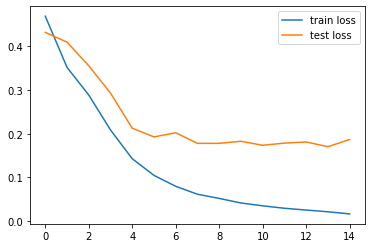

In [50]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [51]:
# Accuracy

p_train = []
y_train = []
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = list((outputs > 0).cpu().numpy())

    # Store predictions
    p_train += predictions
    y_train += list(targets.cpu().numpy())

p_train = np.array(p_train)
y_train = np.array(y_train)
train_acc = np.mean(y_train == p_train)


p_test = []
y_test = []
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    predictions = list((outputs > 0).cpu().numpy())

    # Store predictions
    p_test += predictions
    y_test += list(targets.cpu().numpy())

p_test = np.array(p_test)
y_test = np.array(y_test)
test_acc = np.mean(y_test == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9982, Test acc: 0.9234


In [52]:
# convert outputs to probability
torch.sigmoid(outputs)

tensor([[5.7326e-02],
        [1.1936e-02],
        [2.7748e-02],
        [2.7748e-02],
        [1.0439e-03],
        [3.3940e-03],
        [1.1184e-01],
        [8.3610e-04],
        [1.6025e-03],
        [1.0460e-03],
        [1.1025e-02],
        [1.1025e-02],
        [6.5290e-03],
        [2.8462e-03],
        [2.8462e-03],
        [6.5838e-03],
        [2.8595e-01],
        [2.2321e-03],
        [1.2731e-03],
        [4.1462e-02],
        [7.5816e-04],
        [1.4932e-03],
        [1.2190e-03],
        [7.6981e-04],
        [8.6285e-02],
        [1.1157e-03],
        [1.0024e-03],
        [1.0075e-03],
        [7.8345e-04],
        [2.6923e-03],
        [1.4650e-03],
        [8.9458e-04],
        [7.5934e-01],
        [5.9389e-01],
        [3.4967e-03],
        [9.2281e-04],
        [1.0981e-03],
        [9.5708e-04],
        [9.2241e-04],
        [1.3656e-03],
        [7.5981e-04],
        [7.9603e-01],
        [1.2762e-03],
        [1.2762e-03],
        [1.1514e-03],
        [1

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


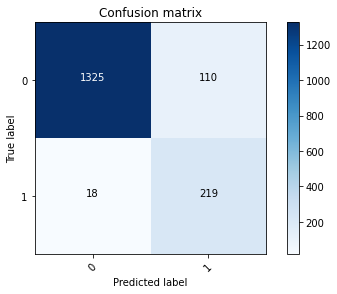

In [54]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, [0, 1])

In [55]:
### Make predictions ###

# get some random test data
df[df.labels == 'spam'].sample(3)

,labels,data,b_labels
3420,spam,Welcome! Please reply with your AGE and GENDER...,1
3162,spam,This is the 2nd time we have tried to contact ...,1
4211,spam,Missed call alert. These numbers called but le...,1


In [56]:
small_sample = df[df.labels == 'spam'].sample(3)
with open('sample_test.csv', 'w') as f:
  f.write("data\n") # header
  for i, row in small_sample.iterrows():
    f.write(row['data'] + "\n")

In [57]:
sample_dataset = ttd.TabularDataset(path='sample_test.csv',
                                    format='csv',
                                    skip_header=True,
                                    fields=[('data', TEXT)])

In [58]:
sample_iter = ttd.Iterator(sample_dataset,
                           batch_size=32,
                           sort_key=lambda x: len(x.data),
                           device=device)

In [59]:
for inputs in sample_iter:
    # Returns a Batch object, not tensor
    print("inputs:", inputs)

    # Forward pass
    outputs = model(inputs.data)

    # Print logits
    print(outputs)

inputs: 
[torchtext.legacy.data.batch.Batch of size 3]
	[.data]:[torch.cuda.LongTensor of size 3x20 (GPU 0)]
tensor([[ 4.3709],
        [ 4.1245],
        [-4.4547]], device='cuda:0', grad_fn=<AddmmBackward>)


In [60]:
single_sentence = 'Our dating service has been asked 2 contact U by someone shy! CALL 09058091870 NOW all will be revealed.'
TEXT.preprocess(single_sentence)

['Our',
 'dating',
 'service',
 'has',
 'been',
 'asked',
 '2',
 'contact',
 'U',
 'by',
 'someone',
 'shy',
 '!',
 'CALL',
 '09058091870',
 'NOW',
 'all',
 'will',
 'be',
 'revealed',
 '.']

In [61]:
TEXT.numericalize([TEXT.preprocess(single_sentence)])

tensor([[ 846,  691,  283,  119,  122,  567,   29,  236,   45,  100,  304, 3905,
            9,  475, 4230,  247,   67,   43,   44, 1966,    2]])

In [62]:
toks = TEXT.preprocess(single_sentence)
sent_idx = TEXT.numericalize([toks])
model(sent_idx.to(device))

tensor([[3.9334]], device='cuda:0', grad_fn=<AddmmBackward>)